# Rating Product & Sorting Reviews in Amazon



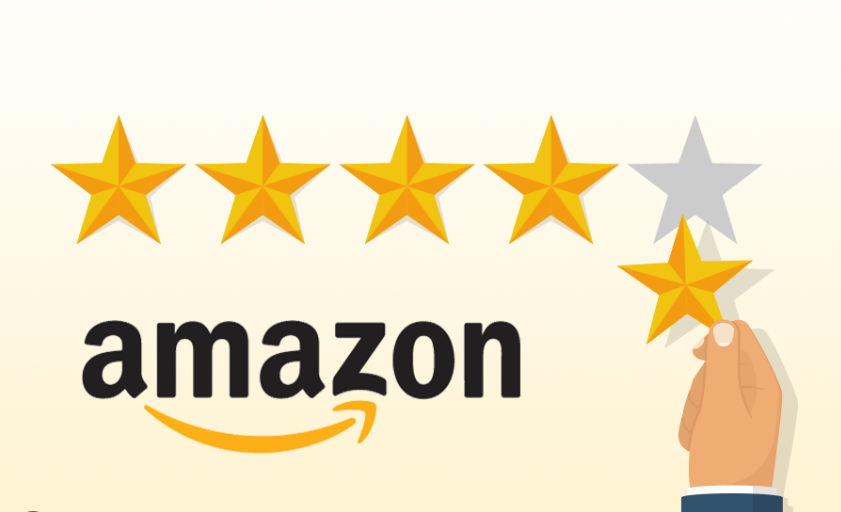

One of the most important problems in e-commerce is the correct calculation of the points given to products after sales. The solution to this problem means providing more customer satisfaction for the e-commerce site, making the product stand out for sellers, and a smooth shopping experience for buyers. Another problem is the correct ordering of the comments given to the products. Highlighting misleading comments will directly affect the sales of the product, causing both financial and customer loss. By solving these 2 basic problems, e-commerce sites and sellers will increase their sales, while customers will complete their purchasing journey without any problems.

**Dataset Story**

This dataset, which includes Amazon product data, includes product categories and various metadata. The product with the most reviews in the electronics category has user ratings and reviews.

reviewerID: User ID

asin: Product ID

reviewerName: Username

helpful: Helpful rating

reviewText: Review

overall: Product rating

summary: Evaluation summary

unixReviewTime: Evaluation time

reviewTime: Reviewtime Raw

day_diff: Number of days since evaluation

helpful_yes: The number of times the review was found helpful

total_vote: Number of votes given to the review


**What is the point?**

**Try to calculate product ratings more accurately and to sort product comments more accurately.**

In [2]:
import pandas as pd
import math
import scipy.stats as st
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [3]:
df = pd.read_csv("amazon_review.csv")

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00000,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00000,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00000,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00000,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00000,best deal around,1373673600,2013-07-13,513,0,0


**Basic Score Calculation**

In [4]:
df["overall"].mean() 

4.587589013224822

**Weighted Average Score by Date**

In [7]:
df.describe()

,overall,unixReviewTime,day_diff,helpful_yes,total_vote
count,4915.00000,4915.00000,4915.00000,4915.00000,4915.00000
mean,4.58759,1379465001.66836,437.36704,1.31109,1.52146
std,0.99685,15818574.32275,209.43987,41.61916,44.12309
min,1.00000,1339200000.00000,1.00000,0.00000,0.00000
25%,5.00000,1365897600.00000,281.00000,0.00000,0.00000
50%,5.00000,1381276800.00000,431.00000,0.00000,0.00000
75%,5.00000,1392163200.00000,601.00000,0.00000,0.00000
max,5.00000,1406073600.00000,1064.00000,1952.00000,2020.00000


In [6]:
df.loc[df["day_diff"] <= 281, "overall"].mean() * 28/100 + \
    df.loc[(df["day_diff"] > 281) & (df["day_diff"] <= 431), "overall"].mean() * 26/100 + \
    df.loc[(df["day_diff"] > 431) & (df["day_diff"] <= 601), "overall"].mean() * 24/100 + \
    df.loc[(df["day_diff"] > 600), "overall"].mean() * 22 / 100

4.595711339224547

**There is no helpful_no variable in the data set, it must be generated from existing variables.**

In [8]:
df["helpful_no"] = df["total_vote"] - df["helpful_yes"]

#  Sort product comments

In [9]:
def score_up_down_diff(up, down):
    return up - down
df["score_pos_neg_diff"] = score_up_down_diff(df["helpful_yes"], df["helpful_no"])

In [10]:
def score_average_rating(up, down):
    if up + down == 0:
        return 0
    return up / (up + down)
df["score_average_rating"] = df.apply(lambda x: score_average_rating(x["helpful_yes"], x["helpful_no"]), axis=1)

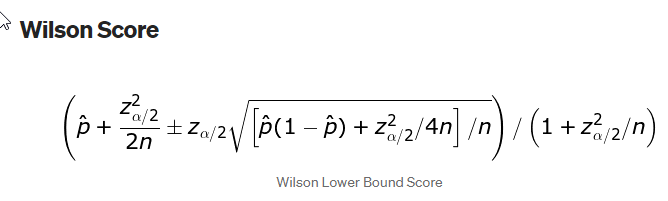

In [11]:
def wilson_lower_bound(up, down, confidence=0.95):
    n = up + down
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * up / n
    return (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)
df["wilson_lower_bound"] = df.apply(lambda x: wilson_lower_bound(x["helpful_yes"], x["helpful_no"]), axis=1)

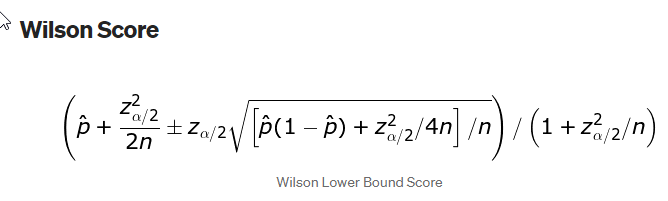

The idea here is to treat the existing set of user ratings as a statistical sampling of a hypothetical set of user ratings from all users and then use this score. In other words, what user community would think about upvoting a product with 95% confidence given that we have an existing rating for this product with a sample (subset from the whole community) user ratings.

Therefore if we know what a sample population thinks i.e. user reviews for a product, you can use this to estimate the preferences of the whole community.

In [12]:
df.sort_values("wilson_lower_bound", ascending=False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,helpful_no,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.00000,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,68,1884,0.96634,0.95754
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.00000,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,77,1351,0.94884,0.93652
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.00000,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,126,1442,0.92562,0.91214
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.00000,"Warning, read this!",1346544000,2012-02-09,1033,422,495,73,349,0.85253,0.81858
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.00000,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,4,41,0.91837,0.80811
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.00000,I own it,1393545600,2014-02-28,283,60,68,8,52,0.88235,0.78465
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.00000,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,27,85,0.80576,0.73214
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.00000,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,649,22,25,3,19,0.88000,0.70044
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.00000,Awesome Card!,1339200000,2012-09-06,823,51,65,14,37,0.78462,0.67033
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.00000,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,27,55,0.75229,0.66359


# Result


score_average_rating(2, 0) # equals 1 

score_average_rating(100, 1) # equals 0.99 getiriyor!

which one is better actually think ! but according to function first is better.The function omits voting information.
So, we use wilson_lower_bound

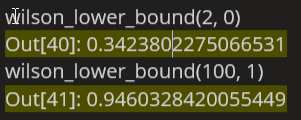